In [1]:
import os
os.chdir('..')
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch_geometric.nn import GCNConv
import torch.optim as optim
from torch_geometric.data import Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from utils.datasets import SkeletonEMGDataset

In [2]:
# dataset = SkeletonEMGDataset(csv_file="emg_skel.csv", window_size=10)

# skel, label = dataset.__getitem__(12)
# print(skel[0])

In [22]:
class Skeleton3DConvNet(nn.Module):
    def __init__(self, output_num):
        super(Skeleton3DConvNet, self).__init__()
        
        self.num_emgs = 8
        self.output_num = output_num
        
        # Define the layers of the network
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=16, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(16)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn2 = nn.BatchNorm3d(32)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn3 = nn.BatchNorm3d(64)
        self.relu3 = nn.ReLU(inplace=True)
        
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.drop = nn.Dropout(0.3)
        
        # 15360
        self.fc1 = nn.LazyLinear(4096)
        self.relu4 = nn.ReLU(inplace=True)
        
        self.fc2 = nn.LazyLinear(1024)
        self.relu5 = nn.ReLU(inplace=True)
        
        self.fc2 = nn.LazyLinear(256)
        self.relu5 = nn.ReLU(inplace=True)
        
        
        self.fc3 = nn.LazyLinear(self.num_emgs * output_num)
        
    def forward(self, x):
        # Input shape: (batch_size, sequence_length, num_joints, 3)
        x = torch.permute(x, (0, 3, 1, 2))
        x = x.unsqueeze(3)
        
        # Apply convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        
        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)
        
        # Apply fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.drop(x)
        
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.drop(x)
        
        x = self.fc3(x)
        x = x.view(x.size(0), self.num_emgs, self.output_num)
        
        return x


def create_edge_index():
    coco_edges = [
        (0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 6), 
        (5, 7), (7, 9), (6, 8), (8, 10), (5, 11), (6, 12), 
        (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)
    ]
    for i in range(17):
        coco_edges.append((i, i))
        
    row, col = torch.tensor(coco_edges).t()
    return torch.stack([row, col], dim=0)


class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__()
        self.gcn = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.gcn(x, edge_index)
    
class GCNNSkeleton(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, output_channels, num_keypoints, output_num):
        super(GCNNSkeleton, self).__init__()
        
        self.num_keypoints = num_keypoints
        self.output_num = output_num
        self.num_emgs = 8
        
        self.gcn1 = GCNConv(num_features, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.gcn3 = GCNConv(hidden_channels, output_channels)
        self.relu = nn.ReLU()

        self.fc = nn.Sequential(
            nn.LazyLinear(1024),
            
            nn.ReLU(),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(self.num_emgs * output_num),
        )

    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = self.relu(x)
        x = self.gcn2(x, edge_index)
        x = self.relu(x)
        x = self.gcn3(x, edge_index)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), self.num_emgs, self.output_num)
        
        return x

In [9]:
dataset = SkeletonEMGDataset(csv_file="emg_skel.csv", window_size=10)
X, Y = dataset.__getitem__(8)
print(torch.max(X))
print(X)

(1920, 1920)
tensor(0.9997)
tensor([[[0.0000, 0.0000, 0.0000],
         [0.2478, 0.1161, 0.0456],
         [0.2543, 0.1149, 0.0625],
         [0.2156, 0.1156, 0.7413],
         [0.2734, 0.1148, 0.7516],
         [0.1854, 0.1736, 0.9948],
         [0.2976, 0.1740, 0.9956],
         [0.1602, 0.2746, 0.9789],
         [0.3209, 0.2726, 0.9845],
         [0.1669, 0.3589, 0.9398],
         [0.3351, 0.3558, 0.9491],
         [0.1988, 0.3338, 0.9996],
         [0.2717, 0.3326, 0.9996],
         [0.1989, 0.4743, 0.9991],
         [0.2612, 0.4747, 0.9993],
         [0.1992, 0.6012, 0.9914],
         [0.2409, 0.6043, 0.9927]],

        [[0.0000, 0.0000, 0.0000],
         [0.2484, 0.1165, 0.0520],
         [0.2548, 0.1153, 0.0632],
         [0.2165, 0.1153, 0.7609],
         [0.2742, 0.1143, 0.7395],
         [0.1862, 0.1724, 0.9954],
         [0.2997, 0.1727, 0.9955],
         [0.1637, 0.2746, 0.9816],
         [0.3223, 0.2713, 0.9835],
         [0.1679, 0.3610, 0.9467],
         [0.3348, 0.3573,

In [10]:
# Create dataset and data loader
dataset = SkeletonEMGDataset(csv_file="emg_skel.csv", n_ahead=12, window_size=10)

train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7, 0.1, 0.2])
trainLoader = DataLoader(train_dataset, batch_size=64, num_workers=8, shuffle=True)
validLoader = DataLoader(valid_dataset, batch_size=64, num_workers=4, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size=64, num_workers=0, shuffle=True)

edge_index = create_edge_index().to(device)
print(edge_index)

print(dataset.cumulative_num_samples)

(1920, 1920)
tensor([[ 0,  0,  1,  2,  3,  4,  5,  5,  7,  6,  8,  5,  6, 11, 11, 13, 12, 14,
          0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
        [ 1,  2,  3,  4,  5,  6,  6,  7,  9,  8, 10, 11, 12, 12, 13, 15, 14, 16,
          0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]],
       device='cuda:0')
[ 1778  3556  5334  7112  8890 10668 12446 14224 16002 17780 19558 21336
 23114 24892 26670 28448 30226 32004 33782 35560 37338 39116 40894 42672
 44450]


In [12]:
# Create model and optimizer
input_channels = 3
hidden_channels = 16
output_channels = 32
num_keypoints = 17
output_num = train_dataset.dataset.n_ahead

model = GCNNSkeleton(input_channels, hidden_channels, output_channels, num_keypoints, output_num).to(device)

# model = Skeleton3DConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define loss function
criterion = nn.MSELoss()

In [13]:
x = None
for i, b in testLoader:
    print(b.shape)
    i = i.to(device)
    print(model(i, edge_index).shape)
    break

torch.Size([64, 8, 12])
torch.Size([64, 8, 12])


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/30: Train Loss: 0.137322 - Validation Loss: 0.024487


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 2/30: Train Loss: 0.025129 - Validation Loss: 0.024674


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 3/30: Train Loss: 0.024348 - Validation Loss: 0.024201


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 4/30: Train Loss: 0.024888 - Validation Loss: 0.024455


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 5/30: Train Loss: 0.024181 - Validation Loss: 0.023925


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 6/30: Train Loss: 0.023944 - Validation Loss: 0.023803


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 7/30: Train Loss: 0.023767 - Validation Loss: 0.024358


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 8/30: Train Loss: 0.023802 - Validation Loss: 0.024020


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 9/30: Train Loss: 0.023741 - Validation Loss: 0.024284


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 10/30: Train Loss: 0.023523 - Validation Loss: 0.023473


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001B1995E3010>
Traceback (most recent call last):
  File "C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\utils\data\dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\gmald\anaconda3\envs\genml\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "C:\Users\gmald\anaconda3\envs\genml\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


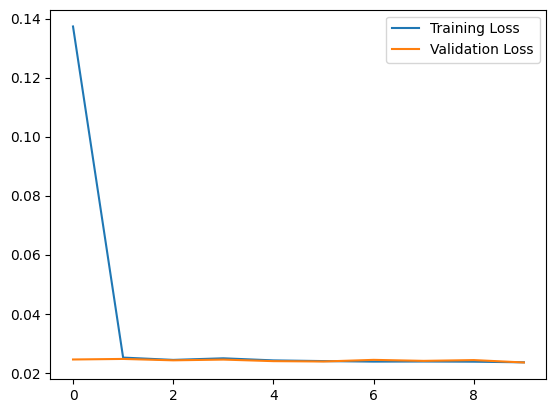

In [9]:
# Train model

edge_index.to(device)
train_losses = []
valid_losses = []

for epoch in range(10):
    # Training
    running_loss = 0.0
    model.train()

    for data in tqdm(trainLoader):
        # Get inputs and labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs, edge_index)
        loss = criterion(outputs, labels)

        # Check if loss is NaN
        if np.isnan(loss.item()):
            # print("Skipping iteration due to NaN loss")
            continue

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainLoader)
    train_losses.append(train_loss)

    # Validation
    running_loss = 0.0
    model.eval()

    with torch.no_grad():
        for data in tqdm(validLoader):
            # Get inputs and labels
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            outputs = model(inputs, edge_index)
            loss = criterion(outputs, labels)

            # Check if loss is NaN
            if np.isnan(loss.item()):
                # print("Skipping iteration due to NaN loss")
                continue

            running_loss += loss.item()

    valid_loss = running_loss / len(validLoader)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{30}: Train Loss: {train_loss:.6f} - Validation Loss: {valid_loss:.6f}")

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.show()

In [23]:
# Create model and optimizer
output_num = train_dataset.dataset.n_ahead

model2 = Skeleton3DConvNet(output_num).to(device)

# model = Skeleton3DConvNet().to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.01)

# Define loss function
criterion = nn.MSELoss()

In [24]:
x = None
for i, b in testLoader:
    print(b.shape)
    i = i.to(device)
    print(model2(i).shape)
    break
    
train_losses = []
valid_losses = []

torch.Size([64, 8, 12])
torch.Size([64, 8, 12])


In [25]:
for epoch in range(10):
    # Training
    running_loss = 0.0
    model2.train()

    for data in tqdm(trainLoader):
        # Get inputs and labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model2(inputs)
        loss = criterion(outputs, labels)

        # Check if loss is NaN
        if np.isnan(loss.item()):
            # print("Skipping iteration due to NaN loss")
            continue

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainLoader)
    train_losses.append(train_loss)

    # Validation
    running_loss = 0.0
    model2.eval()

    with torch.no_grad():
        for data in tqdm(validLoader):
            # Get inputs and labels
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            outputs = model2(inputs)
            loss = criterion(outputs, labels)

            # Check if loss is NaN
            if np.isnan(loss.item()):
                # print("Skipping iteration due to NaN loss")
                continue

            running_loss += loss.item()

    valid_loss = running_loss / len(validLoader)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{30}: Train Loss: {train_loss:.6f} - Validation Loss: {valid_loss:.6f}")

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.show()

  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/30: Train Loss: 388.599044 - Validation Loss: 0.067985


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 2/30: Train Loss: 0.056306 - Validation Loss: 0.045403


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 3/30: Train Loss: 0.037973 - Validation Loss: 0.031934


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 4/30: Train Loss: 0.032015 - Validation Loss: 0.026359


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 5/30: Train Loss: 0.025441 - Validation Loss: 0.024745


  0%|          | 0/487 [00:11<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 6/30: Train Loss: 0.024606 - Validation Loss: 0.024416


  0%|          | 0/487 [00:11<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026F07187010>
Traceback (most recent call last):
  File "C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\utils\data\dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\gmald\anaconda3\envs\genml\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "C:\Users\gmald\anaconda3\envs\genml\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026F07187010>
Traceback (most recent call last):
  File "C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\utils\data\dataloader.py", li

In [12]:
t.extend(train_losses)
v.extend(valid_losses)

In [13]:
len(t)

4

C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 8, 12])) that is different to the input size (torch.Size([1, 8, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(4, 12) [[0.17901555 0.07111575 0.19618139 0.13977927 0.23139024 0.15782224
  0.16832934 0.10824881 0.07602029 0.06288184 0.05973153 0.04992246]
 [0.27270144 0.524297   0.0930688  0.26350722 0.58110994 0.57029635
  0.4277152  0.20669441 0.07547583 0.18152642 0.22725119 0.18937609]
 [0.4542773  0.09673635 0.11270315 0.02949851 0.08910433 0.08198709
  0.05309735 0.05370612 0.2660955  0.23598813 0.18879053 0.30739343]
 [0.15919006 0.2870251  0.250996   0.27074388 0.11138127 0.11969443
  0.06357253 0.16351911 0.41434273 0.49003986 0.19140756 0.35856578]]


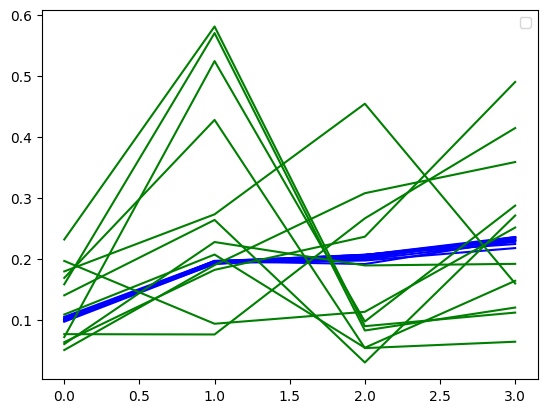

In [28]:
for data, emg in testLoader:
    
    data = data[0].view(1, dataset.window_size, 17, 3).to(device)
    emg = emg[0].view(1, 8, 12).to(device)
    
    with torch.no_grad():
        outputs = model2(data)# , edge_index)
        
    loss = criterion(outputs, labels)
    
    pred = outputs.cpu().numpy()
    target = labels.cpu().numpy()
    
    pred_plot = pred[0, 4:, :]
    target_plot = target[0, 4:, :]
    
    print(pred_plot.shape, target_plot)
    
    # Plot the prediction and target data
    plt.plot(pred_plot, 'b')
    plt.plot(target_plot, 'g')
    
    # Calculate the difference between the prediction and target
    
    # Plot the difference as a separate line
    
    # Add a legend to the plot
    plt.legend()
    
    # Show the plot
    plt.show()
    
    break